In [1]:
from keras import layers
from keras import models
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras import optimizers, regularizers

Using TensorFlow backend.


In [7]:
RESOLUTION = 150
BATCH_SIZE = 128

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.15)
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.15)

train_generator = train_datagen.flow_from_directory(
        '../input/thesimpsonsdatasetfiltered/the-simpsons-dataset/the-simpsons-dataset/top-10/',
        target_size=(RESOLUTION, RESOLUTION),
        class_mode='categorical', subset="training")

val_generator = val_datagen.flow_from_directory(
        '../input/thesimpsonsdatasetfiltered/the-simpsons-dataset/the-simpsons-dataset/top-10/',
        target_size=(RESOLUTION, RESOLUTION),
        class_mode='categorical', subset="validation")

Found 11745 images belonging to 10 classes.
Found 2066 images belonging to 10 classes.


In [8]:
train_generator.class_indices

{'bart_simpson': 0,
 'charles_montgomery_burns': 1,
 'homer_simpson': 2,
 'krusty_the_clown': 3,
 'lisa_simpson': 4,
 'marge_simpson': 5,
 'milhouse_van_houten': 6,
 'moe_szyslak': 7,
 'ned_flanders': 8,
 'principal_skinner': 9}

# Questão 2e.

In [10]:
path = '../input/keras-pretrained-models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
conv_base = VGG16(include_top=False, input_shape=(150, 150, 3), weights=path)
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

In [11]:
# fine tuning

def create_model(conv_base, first_trainable_layer='block5_conv3'): 
    
    model = Sequential()
    model.add(conv_base)
    
    set_trainable = False
    for layer in conv_base.layers:
        if layer.name == first_trainable_layer:
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False
            
    model.add(Flatten())
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=10, activation='softmax'))
    
    return model

In [12]:
model = create_model(conv_base)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                524352    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                650       
Total params: 15,239,690
Trainable params: 2,884,810
Non-trainable params: 12,354,880
_________________________________________________________________


In [13]:
N_TRAIN = 11745
N_VAL = 2066

opt = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit_generator(
train_generator,
steps_per_epoch=(N_TRAIN // BATCH_SIZE),
epochs=50,
validation_data=val_generator,
validation_steps=(N_VAL // BATCH_SIZE) 
)

Epoch 1/50
91/91 [==============================] - 22s 243ms/step - loss: 2.5798 - acc: 0.4609 - val_loss: 1.4246 - val_acc: 0.5703
Epoch 2/50
91/91 [==============================] - 18s 198ms/step - loss: 0.7788 - acc: 0.7493 - val_loss: 0.7997 - val_acc: 0.7422
Epoch 3/50
91/91 [==============================] - 18s 196ms/step - loss: 0.6134 - acc: 0.8101 - val_loss: 0.9547 - val_acc: 0.7031
Epoch 4/50
91/91 [==============================] - 18s 197ms/step - loss: 0.5408 - acc: 0.8341 - val_loss: 0.6428 - val_acc: 0.8223
Epoch 5/50
91/91 [==============================] - 19s 208ms/step - loss: 0.3703 - acc: 0.8970 - val_loss: 0.6938 - val_acc: 0.8133
Epoch 6/50
91/91 [==============================] - 17s 190ms/step - loss: 0.3267 - acc: 0.9001 - val_loss: 0.7239 - val_acc: 0.8320
Epoch 7/50
91/91 [==============================] - 17s 191ms/step - loss: 0.3655 - acc: 0.8905 - val_loss: 0.7073 - val_acc: 0.8203
Epoch 8/50
91/91 [==============================] - 17s 190ms/step - 

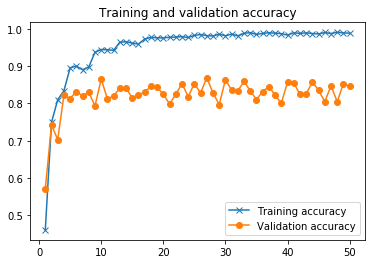

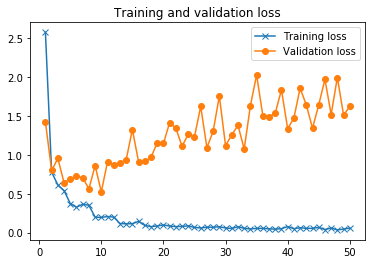

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Training accuracy', marker='x')
plt.plot(epochs, val_acc, label='Validation accuracy', marker='o')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, label='Training loss', marker='x')
plt.plot(epochs, val_loss, label='Validation loss', marker='o')
plt.title('Training and validation loss')
plt.legend()

plt.show()